# Agents
- 에이전트는 언어 모델과 도구를 결합하여 작업에 대해 추론하고, 사용할 도구를 결정하고, 반복적으로 솔루션을 향해 노력하는 시스템을 만듭니다.
- create_agent생산에 바로 사용할 수 있는 에이전트 구현을 제공합니다.
- LLM 에이전트는 목표를 달성하기 위해 루프 내에서 도구를 실행합니다 . 
- 에이전트는 중지 조건이 충족될 때까지, 즉 모델이 최종 출력을 내보내거나 반복 횟수 제한에 도달할 때까지 실행됩니다.
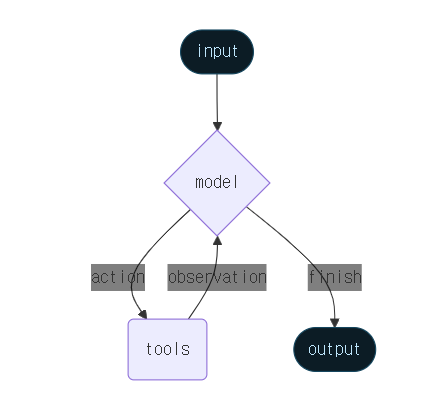

In [ ]:
"""
model ¶	에이전트의 언어 모델입니다. 
문자열 식별자(예: "openai:gpt-4") 또는 직접 채팅 모델 인스턴스(예: ChatOpenAI또는 다른 채팅 모델 )일 수 있습니다.
지원되는 모델 문자열의 전체 목록은 을 참조하세요 init_chat_model.

유형: str | BaseChatModel

tools ¶	도구 목록, dicts또는 Callable.
None또는 빈 목록 인 경우 , 에이전트는 도구 호출 루프가 없는 모델 노드로 구성됩니다.

유형: Sequence[BaseTool | Callable | dict[str, Any]] | None기본: None

system_prompt ¶	LLM에 대한 선택적 시스템 프롬프트입니다.
프롬프트는 a로 변환되어 SystemMessage메시지 목록의 시작 부분에 추가됩니다.

유형: str | None기본: None

middleware ¶	에이전트에 적용할 미들웨어 인스턴스의 시퀀스입니다.
미들웨어는 다양한 단계에서 에이전트의 동작을 가로채고 수정할 수 있습니다. 전체 가이드를 참조하세요 .

유형: Sequence[AgentMiddleware[StateT_co, ContextT]]기본: ()

response_format ¶	구조화된 응답을 위한 선택적 구성입니다.
ToolStrategy, , 또는 Pydantic 모델 클래스가 될 수 있습니다 ProviderStrategy.

제공된 경우, 에이전트는 대화 흐름 중에 구조화된 출력을 처리합니다. 
원시 스키마는 모델 기능에 따라 적절한 전략으로 래핑됩니다.

유형: ResponseFormat[ResponseT] | type[ResponseT] | None기본: None

state_schema ¶	TypedDict.을 확장하는 선택적 스키마입니다 AgentState.
이 스키마가 제공되면 AgentState미들웨어 상태 스키마와 병합할 때 기본 스키마 대신 사용됩니다. 
이를 통해 사용자는 사용자 지정 미들웨어를 생성하지 않고도 사용자 지정 상태 필드를 추가할 수 있습니다. 
일반적으로 state_schema관련 확장의 범위를 해당 후크/도구로 제한하기 위해 미들웨어를 통한 확장을 사용하는 것이 좋습니다.

스키마는 .의 하위 클래스여야 합니다 AgentState[ResponseT].

유형: type[AgentState[ResponseT]] | None기본: None

context_schema ¶	런타임 컨텍스트에 대한 선택적 스키마입니다.
유형: type[ContextT] | None기본: None

checkpointer ¶	선택적 체크포인트 세이버 객체입니다.
단일 스레드(예: 단일 대화)에 대한 그래프 상태(예: 채팅 메모리)를 유지하는 데 사용됩니다.

유형: Checkpointer | None기본: None

store ¶	선택적 저장 객체입니다.
여러 스레드(예: 여러 대화/사용자)에 걸쳐 데이터를 유지하는 데 사용됩니다.

유형: BaseStore | None기본: None

interrupt_before ¶	중단하기 전에 노드 이름을 나열한 선택적 목록입니다.
작업을 수행하기 전에 사용자 확인이나 기타 인터럽트를 추가하려는 경우에 유용합니다.

유형: list[str] | None기본: None

interrupt_after ¶	인터럽트할 노드 이름의 선택적 목록입니다.
출력에 직접 반환하거나 추가 처리를 실행하려는 경우에 유용합니다.

유형: list[str] | None기본: None

debug ¶	그래프 실행에 대한 자세한 로깅을 활성화할지 여부입니다.
활성화하면 에이전트 런타임 중 각 노드 실행, 상태 업데이트 및 전환에 대한 자세한 정보가 출력됩니다. 
미들웨어 동작 디버깅 및 에이전트 실행 흐름 이해에 유용합니다.

유형: bool기본: False

name ¶	. 에 대한 선택적 이름입니다 CompiledStateGraph.
이 이름은 에이전트 그래프를 다른 그래프에 하위 그래프 노드로 추가할 때 자동으로 사용됩니다. 
특히 다중 에이전트 시스템을 구축하는 데 유용합니다.

유형: str | None기본: None

cache ¶	BaseCache그래프 실행 캐싱을 활성화하는 선택적 인스턴스입니다.
유형: BaseCache | None기본: None
"""

In [5]:
"""
에이전트 노드는 시스템 프롬프트를 적용한 후 메시지 목록을 사용하여 언어 모델을 호출합니다. 
결과에 AIMessage가 포함 되면 tool_calls그래프는 도구를 호출합니다. 
도구 노드는 도구를 실행하고 응답을 메시지 목록에 ToolMessage객체로 추가합니다. 
그런 다음 에이전트 노드는 언어 모델을 다시 호출합니다. 
tool_calls응답에 더 이상 존재하지 않을 때까지 이 프로세스가 반복됩니다. 
그런 다음 에이전트는 전체 메시지 목록을 반환합니다.
"""
from langchain.agents import create_agent
def check_weather(location: str) -> str:
    '''Return the weather forecast for the specified location.'''
    return f"It's always sunny in {location}"

graph = create_agent(
    model="gpt-4o-mini",
    tools=[check_weather],
    system_prompt="You are a helpful assistant",
)
inputs = {"messages": [{"role": "user", "content": "what is the weather in sf"}]}
for chunk in graph.stream(inputs, stream_mode="updates"):
    print(chunk)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 58, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CbMHF7U5uHCjCVCaeDW9Cg1Thutjy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--76173ff8-1487-4a89-b751-936f37e56187-0', tool_calls=[{'name': 'check_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_mncn4MzXYLxqT8XHwerGvgvk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 15, 'total_tokens': 73, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

# 동적 모델
- 동적 모델은 다음에서 선택됩니다.
- 현재 상태와 컨텍스트(맥락)에 따라 실행 시점(runtime)에 선택되는 모델을 말합니다.
- 이렇게 하면 **복잡한 라우팅 로직(어떤 모델을 쓸지 자동으로 고르는 로직)**과 비용 최적화를 할 수 있습니다.
- 다이내믹 모델을 사용하려면, @wrap_model_call 데코레이터를 사용해 미들웨어를 만들고,
- 이 미들웨어 안에서 요청(request)에 사용되는 모델을 수정해 주면 됩니다.

- 용어 정리
    - runtime(실행 시점)
        - 코드가 “돌아가고 있는 순간”에 그때그때 어떤 모델을 쓸지 결정한다는 의미.
    - routing logic(라우팅 로직)
        - “이 요청은 작은 모델로 처리해도 돼”
        - “이건 중요한 요청이니까 큰 모델로 보내자”
        - 이렇게 요청 → 적절한 모델로 보내는 규칙/로직.
    - middleware(미들웨어)
        - 요청이 실제 모델에 도달하기 전/후에 중간에서 요청·응답을 가공하는 층
        - 여기서 “어떤 모델을 쓸지 바꿔 끼우는 역할”을 담당.
    - @wrap_model_call 데코레이터
        - 모델 호출 함수를 감싸서,
        - 호출 전에 모델 선택/변경 로직을 넣을 수 있게 해주는 장치라고 보면 됨.


In [6]:
from langchain_openai import ChatOpenAI
# 왜: OpenAI 채팅 모델을 LangChain 인터페이스로 사용하기 위해.

from langchain.agents import create_agent
# 왜: 에이전트(툴콜 루프 포함) 그래프를 손쉽게 생성.

from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse
# 왜: LLM 호출 직전에 개입할 수 있는 미들웨어 유틸리티와 요청/응답 타입.
#    - wrap_model_call: 미들웨어 함수 데코레이터
#    - ModelRequest: 1회 LLM 호출의 요청 컨테이너(모델/메시지/상태 등)
#    - ModelResponse: 1회 LLM 호출의 응답 컨테이너


basic_model = ChatOpenAI(model="gpt-4o-mini")
# 무엇: 기본(저비용/경량) 모델 인스턴스. 짧은 대화/간단 작업에 사용.

advanced_model = ChatOpenAI(model="gpt-4o")
# 무엇: 고성능(고비용) 모델 인스턴스. 긴 대화/난이도 높은 추론에 사용.


@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    """
    왜: '모델 호출 직전'에 요청 내용을 보고 어떤 모델을 쓸지 동적으로 결정.
    흐름:
      (1) create_agent의 실행 중 LLM을 호출하려 할 때,
      (2) 이 미들웨어가 request를 받음 → 조건 판단 후 request.model 교체,
      (3) handler(request)로 다음 단계(실제 모델 호출)를 진행,
      (4) 결과(ModelResponse)를 그대로 반환.
    """
    message_count = len(request.state["messages"])
    # 무엇: 현재까지의 대화 길이를 기준으로 복잡도를 간단히 추정.
    # 주의: '길이'는 토큰 수와 다름. 더 정확히 하려면 토큰 카운팅을 권장.

    if message_count > 10:
        # 조건: 대화가 길면(>10 메시지) 더 똑똑한 모델로 승급
        model = advanced_model
    else:
        # 그 외에는 기본 모델 사용
        model = basic_model

    request.model = model
    # 핵심: 이번 호출에서 사용할 모델을 '교체'한다.
    # create_agent에 넘긴 기본 model보다 '이 값'이 우선 적용됨.

    return handler(request)
    # 무엇: 체인을 이어서 실제 모델 호출을 수행.
    # handler는 '다음 미들웨어 → 모델 호출' 파이프라인을 의미.
    # 반환값은 ModelResponse로, 이후 에이전트 루프가 계속 진행.


agent = create_agent(
    model=basic_model,              # 기본값(미들웨어가 없을 때 사용될 모델)
    tools=tools,                    # 에이전트가 호출할 수 있는 툴 목록
    middleware=[dynamic_model_selection]  # 위에서 정의한 미들웨어 적용(순서대로 실행)
)
# 흐름 정리:
#  - 에이전트가 한 턴을 처리할 때마다 LLM 호출 직전에 dynamic_model_selection이 실행
#  - request.state["messages"] 길이를 보고 현재 턴의 model을 결정
#  - 이후 툴콜/재호출 반복 중 매번 조건이 재평가되어 '턴별로' 모델이 달라질 수 있음


NameError: name 'tools' is not defined

## 도구 (Tools)
- 도구는 에이전트가 행동을 수행할 수 있게 해줍니다. 에이전트는 단순히 “모델에 도구를 한 번 바인딩”하는 수준을 넘어, 다음을 지원합니다
    - 여러 개의 도구 호출을 순차적으로 실행(하나의 프롬프트로 트리거)
    - 필요 시 병렬 도구 호출
    - 이전 결과에 기반한 동적 도구 선택
    - 도구 재시도 로직 및 오류 처리
    - 도구 호출 사이의 상태 지속성(persistence)

## 도구 정의 
- 에이전트에게 도구 목록을 전달합니다.
- 빈 도구 목록이 제공되면 에이전트는 도구 호출 기능이 없는 단일 LLM 노드로 구성

In [7]:
from langchain.tools import tool
# 무엇: 일반 파이썬 함수를 LangChain "Tool" 프로토콜로 래핑하는 데코레이터를 가져옴
# 왜: 에이전트가 LLM 응답 중 tool_calls를 내보냈을 때, 이 함수들을 실제로 실행 가능하게 하려는 것

from langchain.agents import create_agent
# 무엇: LLM + (필요 시) 도구 호출 루프를 자동으로 처리하는 에이전트를 생성하는 팩토리
# 흐름: 모델 응답 → tool_calls 있으면 해당 툴 실행 → 결과를 메시지로 합치고 재호출… 반복


@tool
def search(query: str) -> str:
    """Search for information."""
    # 왜: 이 함수의 docstring은 툴 설명(description)으로 사용됨 → LLM이 언제/어떻게 써야 할지 힌트 제공
    # 무엇: 문자열 인자 `query`를 받아 "검색 결과"처럼 보이는 응답을 돌려주는 데모용 툴
    return f"Results for: {query}"
    # 흐름: 에이전트가 tool_calls로 {"tool_name":"search","arguments":{"query":"..."}}
    #       를 요청하면 이 함수가 실행되고 문자열 결과가 ToolMessage로 대화 히스토리에 추가됨


@tool
def get_weather(location: str) -> str:
    """Get weather information for a location."""
    # 무엇: 특정 위치의 날씨 정보를 반환하는 데모용 툴
    # 왜: 타입힌트(location: str) 덕분에 LLM이 인자 형태를 더 정확하게 추론/직렬화할 수 있음
    return f"Weather in {location}: Sunny, 72°F"
    # 실제 구현에선 외부 API 호출/에러 처리/단위 변환 등을 수행할 수 있음


agent = create_agent(model, tools=[search, get_weather])
# 무엇: 에이전트 그래프를 생성. `model`은 사용할 LLM(예: ChatOpenAI/Anthropic 등)
# 왜: tools 목록으로 @tool 데코레이터가 감싼 두 함수를 전달 → 에이전트가 필요 시 선택적으로 호출
# 흐름(전체):
#   1) 사용자 프롬프트 입력 → LLM 호출
#   2) LLM이 판단: "검색" 필요? → tool_calls에 'search' 호출을 기재
#   3) 프레임워크가 실제 `search()` 실행 → 결과를 ToolMessage로 messages에 합침
#   4) LLM을 다시 호출해 툴 결과를 반영한 최종 답변 생성
#   5) 같은 방식으로 `get_weather`도 호출 가능. 더 이상 tool_calls 없으면 종료


NameError: name 'model' is not defined

## 도구 오류 처리(Tool error handling)
- 도구 오류가 처리되는 방식을 사용자 지정하려면 
- @wrap_tool_call데코레이터를 사용하여 미들웨어를 만듭니다.
- ToolMessage도구가 실패하면 에이전트는 사용자 지정 오류 메시지와 함께 다음을 반환


In [8]:
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_tool_call
from langchain_core.messages import ToolMessage


@wrap_tool_call
def handle_tool_errors(request, handler):
    """Handle tool execution errors with custom messages."""
    try:
        return handler(request)
    except Exception as e:
        # Return a custom error message to the model
        return ToolMessage(
            content=f"Tool error: Please check your input and try again. ({str(e)})",
            tool_call_id=request.tool_call["id"]
        )

agent = create_agent(
    model="gpt-4o",
    tools=[search, get_weather],
    middleware=[handle_tool_errors]
)

In [9]:
# [
#     ...
#     ToolMessage(
#         content="Tool error: Please check your input and try again. (division by zero)",
#         tool_call_id="..."
#     ),
#     ...
# ]

In [10]:
from langchain.agents import create_agent
# 무엇: LLM + (툴 호출 루프) 에이전트를 만들어주는 팩토리.
# 흐름: 모델 응답 → tool_calls 있으면 툴 실행 → 결과(또는 에러)를 메시지에 합쳐 다시 모델 호출… 반복.

from langchain.agents.middleware import wrap_tool_call
# 무엇: "툴을 실제 실행하는 순간"을 가로채는 미들웨어 데코레이터.
# 왜: 툴 에러 공통 처리(재시도/로그/마스킹)를 중앙집중식으로 넣기 위함.

from langchain_core.messages import ToolMessage
# 무엇: "툴 호출의 결과"를 모델에게 전달하는 메시지 타입.
# 왜: LLM은 tool_calls로 툴을 요청하고, 에이전트는 ToolMessage로 해당 호출의 결과(성공/실패)를 연결해 돌려줌.


@wrap_tool_call
def handle_tool_errors(request, handler):
    """
    왜: 툴 실행 시 발생하는 모든 예외를 여기서 잡아
        모델이 이해할 수 있는 '안전한 에러 메시지'로 반환(누설 방지)하려고.
    무엇: wrap_tool_call로 감싼 함수는 각 툴 실행마다 호출되는 '미들웨어 훅'.
    인자:
      - request: 툴 실행 컨텍스트(어떤 툴, 인자, tool_call 메타 등)
      - handler: 실제 툴을 실행하는 콜백. (request -> ToolMessage 반환)
    반환:
      - 일반적으로 handler(request)의 결과(ToolMessage)
      - 에러 시: 커스텀 ToolMessage(에러 설명)
    """
    try:
        return handler(request)  # 흐름: 정상 케이스 → 실제 툴을 실행하고 결과를 그대로 반환
    except Exception as e:
        # 무엇: 모든 예외를 잡아 모델 친화적인 에러 메시지로 변환
        # 왜: 스택트레이스/민감정보를 그대로 노출하지 않기 위해 메시지를 '마스킹'해서 전달
        return ToolMessage(
            content=f"Tool error: Please check your input and try again. ({str(e)})",
            # 무엇: tool_call_id는 "어떤 툴 호출에 대한 응답인지"를 모델이 매칭할 수 있게 하는 식별자
            # 왜: 모델은 여러 병렬/연속 툴 호출을 할 수 있으므로, 응답을 정확히 연결해야 함
            tool_call_id=request.tool_call["id"]
        )


agent = create_agent(
    model="gpt-4o",                 # 무엇: 에이전트가 기본으로 사용할 LLM
    tools=[search, get_weather],    # 무엇: LLM이 호출할 수 있는 툴 목록(@tool로 래핑된 함수들)
    middleware=[handle_tool_errors] # 무엇: 위에서 만든 툴-에러 미들웨어를 적용
)
# 전체 흐름:
# 1) 모델이 tool_calls로 예: {"id":"call-1","name":"search","args":{"query":"..."}}
# 2) 에이전트가 search 툴 실행 직전에 handle_tool_errors 미들웨어 호출
# 3) 정상: handler(request) → ToolMessage(content="Results...", tool_call_id="call-1")
#    에러: except → ToolMessage(content="Tool error: ...", tool_call_id="call-1")
# 4) 이 ToolMessage가 messages에 추가되고, 모델은 그 결과(또는 에러)를 읽고 다음 행동(재시도/다른 툴/최종답변)을 결정


## ReAct루프에서의 도구 사용(Tool use in the ReAct loop)
- 에이전트는 ReAct("추론 + 행동") 패턴을 따르며, 
- 간단한 추론 단계와 타겟 도구 호출을 번갈아가며 수행하고, 
- 최종 답변을 제공할 때까지 결과 관찰 결과를 후속 결정에 반영합니다.

In [ ]:
# ============================== 사용자 메시지 ==============================
# 지금 가장 인기 있는 무선 헤드폰을 찾아보고, 재고가 있는지 확인해줘.

# 추론: 인기는 시간에 따라 변하므로 제공된 검색 도구를 사용해야 한다.
# 행동: call search_products({"query": "wireless headphones"})

# =============================== AI 메시지 ================================
# 도구 호출:
#   search_products (call_abc123)
#   인자:
#     query: "wireless headphones"

# =============================== 도구 메시지 ===============================
# "wireless headphones"와 일치하는 제품 5개를 찾았습니다.
# 상위 5개: WH-1000XM5, ...

# 추론: 답변하기 전에 상위 항목의 재고를 확인해야 한다.
# 행동: call check_inventory({"product_id": "WH-1000XM5"})

# =============================== AI 메시지 ================================
# 도구 호출:
#   check_inventory (call_def456)
#   인자:
#     product_id: "WH-1000XM5"

# =============================== 도구 메시지 ===============================
# 제품 WH-1000XM5: 재고 10개

# 추론: 가장 인기 있는 모델과 재고 현황을 파악했다. 이제 최종 답변을 작성한다.
# 행동: (최종)

# =============================== AI 메시지 ================================
# 인기 무선 헤드폰 WH-1000XM5를 찾았고, 현재 재고는 10개입니다. ...

## 시스템 프롬프트
- 프롬프트를 제공하여 에이전트가 작업에 접근하는 방식을 구체화할 수 있습니다. 
- system_prompt 매개변수는 문자열로 제공될 수 있습니다.
- system_prompt가 제공안되면 에이전트는 메시지에서 직접 작업을 추론합니다.

In [ ]:
agent = create_agent(
    model,
    tools,
    system_prompt="You are a helpful assistant. Be concise and accurate."
# 무엇: 시스템 메시지(역할/톤/정책). create_agent가 SystemMessage로 변환해 대화 맨 앞에 고정 삽입.
# 왜: “간결하고 정확하게” 답하라는 전역 규칙을 모델에 강하게 주입.
# 흐름: [SystemMessage] + [대화 히스토리] → LLM 호출 → (필요 시) 도구 호출 → 최종 답변.
)

"""
모델 파라미터 명시: 재현성을 위해 temperature=0.2 같은 하이퍼파라미터를 model 생성 시 지정하세요.
툴 스키마: 툴의 인자 타입힌트 + docstring을 정확히 써야 모델이 인자를 제대로 직렬화합니다.
메모리/중단(HITL): 장기 대화나 승인 게이트가 필요하면 
checkpointer=(예: InMemorySaver/DB Saver)와 HumanInTheLoop 미들웨어를 함께 고려하세요.
요약(Summary): 대화가 길어지면 SummarizationMiddleware(...)로 토큰/비용을 관리하세요.
검증(Structured Output): 스키마가 필요한 작업이면 
response_format=YourSchema로 구조화 출력을 강제하면 다운스트림 로직이 안정적입니다.
"""

## 동적 시스템 프롬프트
- 런타임 컨텍스트나 에이전트 상태에 따라 시스템 프롬프트를 수정해야 하는 고급 사용 사례의 경우 미들웨어를 사용할 수 있습니다 .
- 데코레이터 @dynamic_prompt는 모델 요청에 따라 동적으로 시스템 프롬프트를 생성하는 미들웨어를 생성합니다.

In [25]:
from typing import TypedDict
# 무엇: 딕셔너리 형태의 스키마(키-값 타입 명세)를 만들기 위한 표준 타입 도구.
# 왜: 런타임 컨텍스트의 "모양"을 코드 레벨에서 명확히 선언해 타입 안정성을 높임.
# 흐름: 아래 Context 클래스 정의에 사용 → create_agent(context_schema=Context)로 이어짐.

from langchain.agents import create_agent
# 무엇: LLM + (필요 시) 도구 호출 루프를 손쉽게 구성하는 팩토리 함수.
# 흐름: model/system_prompt/tools/middleware/context_schema 등을 받아 '에이전트 그래프'를 생성.

from langchain.agents.middleware import dynamic_prompt, ModelRequest
# 무엇:
#  - dynamic_prompt: "시스템 프롬프트를 동적으로 생성/치환"하는 미들웨어 데코레이터.
#  - ModelRequest: 미들웨어 훅이 받는 요청 컨테이너 타입 (모델, 메시지, 상태, runtime 등 포함).
# 왜: 모델 호출 직전에 프롬프트를 가로채 가공할 수 있게 해줌.
# 흐름: @dynamic_prompt로 감싼 함수가 create_agent의 middleware로 들어가고,
#       매 턴 LLM 호출 직전에 호출되어 system prompt를 결정/치환함.


class Context(TypedDict):
    user_role: str
# 무엇: 런타임 컨텍스트의 스키마(형태)를 정의. 여기서는 user_role만 필요.
# 왜: 에이전트 실행 시 "context={"user_role":"expert"}"와 같은 값을 안전하게 전달/검증.
# 흐름: create_agent(context_schema=Context)에 전달 → agent.invoke(context=...)에서 타입 일치 보장.


@dynamic_prompt
def user_role_prompt(request: ModelRequest) -> str:
    """Generate system prompt based on user role."""
    # 무엇: dynamic_prompt 미들웨어 함수. LLM 호출 직전에 불려 '시스템 프롬프트' 문자열을 반환.
    # 왜: 사용자 역할(expert/beginner/user)에 따라 말투/깊이/스타일을 달리 하기 위함.
    # 흐름: create_agent(middleware=[user_role_prompt])로 등록 → 각 턴 시작 시 호출되어
    #       반환한 문자열이 SystemMessage로 주입됨(기존 system_prompt를 대체하거나 결합, 구현에 따라 다름).

    user_role = request.runtime.context.get("user_role", "user")
    # 무엇: 호출 시점의 런타임 컨텍스트에서 user_role을 읽음. 없으면 "user" 기본값.
    # 왜: 미들웨어가 외부(호출자)로부터 상황 정보를 받아 프롬프트를 다이나믹하게 만들기 위함.
    # 흐름: agent.invoke(..., context={"user_role":"expert"}) → 여기에서 사용.

    base_prompt = "You are a helpful assistant."
    # 무엇: 공통 베이스 문구(역할/톤의 기본 규칙).
    # 왜: 공통 정책은 유지하되, 아래에서 역할별 문구를 덧붙이는 패턴으로 재사용성↑.

    if user_role == "expert":
        return f"{base_prompt} Provide detailed technical responses."
        # 무엇: 전문가 모드 → 기술적/깊이 있는 설명 지향.
        # 흐름: 반환 즉시 이 문자열이 이번 턴의 SystemMessage로 주입되어 모델 거동에 영향.

    elif user_role == "beginner":
        return f"{base_prompt} Explain concepts simply and avoid jargon."
        # 무엇: 초보자 모드 → 쉬운 설명, 전문용어 최소화.

    return base_prompt
    # 무엇: 그 외(기본) 모드 → 베이스 문구 그대로 사용.
    # 팁: 역할이 더 늘면 elif 블록으로 확장(executive, manager, designer 등).


agent = create_agent(
    model="gpt-4o",
    # 무엇: 기본으로 사용할 LLM(문자열 식별자 또는 ChatOpenAI 인스턴스).
    # 왜: 각 턴의 응답 생성/툴콜 판단의 중심.

    # tools=[web_search],
    # 무엇: LLM이 필요 시 호출할 수 있는 도구 목록(예: 웹 검색).
    # 흐름: 모델이 tool_calls를 제안 → 프레임워크가 실제 실행 → 결과를 ToolMessage로 합치고 재호출.

    middleware=[user_role_prompt],
    # 무엇: 위에서 정의한 dynamic_prompt 미들웨어를 장착.
    # 왜: 매 턴 모델 호출 직전에 '역할 기반 시스템 프롬프트'로 치환/주입.
    # 흐름: messages 빌드 → (미들웨어) system prompt 생성/주입 → LLM 호출 → (필요 시) 툴 호출.

    context_schema=Context
    # 무엇: 컨텍스트 스키마를 등록해, invoke(context=...)로 들어올 키/타입을 명시.
    # 왜: 잘못된 컨텍스트(키 누락/타입 오류)를 조기에 방지.
    # 흐름: 아래 agent.invoke에서 context={"user_role":"expert"}가 들어오면 이 스키마로 적합성 보장.
)

# The system prompt will be set dynamically based on context
result = agent.invoke(
    {"messages": [{"role": "user", "content": "머신러닝이란?"}]},
    # 무엇: 사용자 입력(질문). create_agent 규약상 messages 리스트로 전달.
    # 흐름: 이 입력 + (미들웨어 생성한 SystemMessage) → LLM 호출 → (필요 시) web_search 도구 호출 → 최종 응답.

    context={"user_role": "beginner"}
    # 무엇: 이번 호출의 런타임 컨텍스트. 미들웨어에서 request.runtime.context로 접근 가능.
    # 왜: 역할을 expert로 지정하면, 미들웨어가 "기술적으로 자세히" 설명하는 시스템 프롬프트를 구성.
    # 흐름: user_role_prompt → "Provide detailed technical responses."가 붙은 SystemMessage 생성.
)
# 결과: result에는 메시지 히스토리와 최종 AIMessage(전문가 톤의 ML 설명)가 포함.

print(result['messages'][-1].content)

머신러닝은 컴퓨터에게 데이터를 통해 특정 작업을 수행하는 법을 배우게 하는 기술입니다. 간단히 말하자면, 컴퓨터가 사람처럼 스스로 경험을 통해 학습할 수 있도록 돕는 것입니다.

예를 들어, 이메일 서비스를 사용하는데 스팸 메일을 자동으로 분류해주는 기능이 있다고 해봅시다. 머신러닝 기법을 사용하면, 컴퓨터는 많은 이메일 데이터를 보고 어떤 것이 스팸이고 어떤 것이 정당한 메일인지 스스로 배우게 됩니다. 그렇게 되면 컴퓨터가 새로 들어오는 이메일이 스팸인지 아닌지를 자동으로 구분할 수 있게 됩니다.

머신러닝은 사람의 개입 없이 스스로 데이터를 분석해서 패턴을 찾아내고, 그 패턴을 바탕으로 예측이나 결정을 내리는 데에 사용됩니다. 이는 다양한 분야에서 활용되고 있으며, 이미지 인식, 음성 인식, 추천 시스템 등 다양한 곳에서 머신러닝 기술이 쓰이고 있습니다.


## Invocation
- 에이전트는 State(상태) 에 “업데이트”를 전달해서 호출할 수 있습니다.
- 모든 에이전트의 상태에는 메시지들의 시퀀스가 포함되어 있으며,
- 에이전트를 호출하려면 여기에 새 메시지를 추가해서 전달하면 됩니다.

In [ ]:
result = agent.invoke(
    {"messages": [{"role": "user", "content": "What's the weather in San Francisco?"}]}
)
"""
에이전트에서 단계(step)별 실행 과정이나 토큰을 스트리밍 형태로 받고 싶다면,
스트리밍 가이드를 참고하세요.

그 외에는, 이 에이전트는 LangGraph의 Graph API를 따르며,
stream 과 invoke 같은 관련 메서드들을 모두 지원합니다.
"""

## Advanced concepts (고급 개념)
### Structured output (구조화된 출력)
- 어떤 상황에서는, 에이전트가 특정 형식(schema)에 맞춰 결과를 반환하길 원할 수 있습니다.
- LangChain은 response_format 파라미터를 통해 구조화된 출력(Structured output)을 제공하는 전략들을 지원합니다.

### ToolStrategy

- ToolStrategy 는 인공적인(tool-based) 도구 호출을 활용하여 구조화된 출력을 생성합니다.
- 이 방식은 도구 호출을 지원하는 어떤 모델이든 사용할 수 있습니다.

In [27]:
from pydantic import BaseModel
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy


class ContactInfo(BaseModel):
    name: str
    email: str
    phone: str

agent = create_agent(
    model="gpt-4o-mini",
    # tools=[search_tool],
    response_format=ToolStrategy(ContactInfo)
)

result = agent.invoke({
    "messages": [{"role": "user", "content": "Extract contact info from: John Doe, john@example.com, (555) 123-4567"}]
})

result["structured_response"]



ContactInfo(name='John Doe', email='john@example.com', phone='(555) 123-4567')

### ProviderStrategy
- ProviderStrategy는 모델 제공자(예:OpenAI)가 제공하는 네이티브 structured output 기능을 사용
- 이 방식은 보다 신뢰도가 높지만, 해당 기능을 네이티브로 지원하는 제공자에서만 사용 할수 있습니다.(예:OpenAI)

In [28]:
from langchain.agents.structured_output import ProviderStrategy

agent = create_agent(
    model = "gpt-4o",
    response_format=ProviderStrategy(ContactInfo)
)
"""
langchain 1.0 기준으로,
단순히 response_format=ContactInfo 처럼 schema만 바로 넘기는 방식은 더 이상 지원되지 않습니다.
반드시 ToolStrategy 또는 ProviderStrategy 를 명시적으로 사용해야 합니다.

구조화된 출력에 대한 더 자세한 내용은 Structured output 문서를 참고하세요.
"""
agent.invoke({
    "messages": [{"role": "user", "content": "Extract contact info from: Jane Smith"}]
})

{'messages': [HumanMessage(content='Extract contact info from: Jane Smith', additional_kwargs={}, response_metadata={}, id='575bb582-04f1-4c8a-a4dd-f82a58935049'),
  AIMessage(content='{"name":"Jane Smith","email":"Not provided","phone":"Not provided"}', additional_kwargs={'parsed': None, 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 84, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b1442291a8', 'id': 'chatcmpl-CbMsTmqqJRnQzPmV7LIdDCdOMlPks', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--dbd3c32d-d659-402b-bc9e-35ab1a0e558b-0', usage_metadata={'input_tokens': 84, 'output_tokens': 21, 'total_tokens': 105, 'input_token_details': {'audio':

In [ ]:
from typing import Any
from pydantic import BaseModel
# 무엇: 구조화된 출력의 "스키마"를 정의하기 위해 사용하는 모델 베이스 클래스.
# 왜: ContactInfo 같은 형태(필드/타입)를 명확히 선언 → LLM 응답을 여기에 맞춰 강제.
from langchain.agents import create_agent
from langchain.agents.structured_output import ProviderStrategy
# 무엇: "모델 제공자의 네이티브 구조화 출력 기능"을 사용하는 전략.
# 왜: OpenAI(gpt-4o 등)의 JSON Schema 기반 structured output을 직접 활용하기 위해.

from langchain_openai import ChatOpenAI
# 무엇: OpenAI 채팅 모델 래퍼. 문자열 "gpt-4o" 대신 인스턴스로도 넘길 수 있음.

# 1) 구조화 출력 스키마 정의 -------------------------------------
class ContactInfo(BaseModel):
    """연락처 정보 스키마"""
    name: str
    email: str
    phone: str

# 2) LLM 인스턴스 생성 -------------------------------------------
llm = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0,
)
# 왜 인스턴스를 쓰냐?
# - 나중에 max_tokens, timeout, extra_headers 등 더 세밀하게 제어할 수 있음.
# - 문자열로 model만 넘기는 것도 가능하지만, 인스턴스를 쓰면 확장성이 좋음.


# 3) Agent 생성: ProviderStrategy로 구조화 출력 활성화 ----------
agent = create_agent(
    model=llm,
    # 또는 model="gpt-4o" 도 가능하지만, 일단 llm 인스턴스를 넘겼다고 가정.

    # 여기 포인트: response_format=ProviderStrategy(ContactInfo)
    response_format=ProviderStrategy(ContactInfo),
    # 무엇:
    #   - "이번 에이전트는 응답을 ContactInfo 형태로 구조화해서 돌려줘"
    #   - ProviderStrategy는 OpenAI의 native structured output (JSON schema)을 사용.
    # 흐름:
    #   - agent.invoke(...) 호출 시,
    #   - LangChain이 OpenAI API 요청에 JSON Schema를 같이 보내서
    #   - 모델이 ContactInfo에 맞는 JSON을 생성하도록 유도.
)

# 4) 호출 예시 ---------------------------------------------------
if __name__ == "__main__":
    user_text = "연락처: John Doe, john@example.com, (555) 123-4567"
    result: dict[str, Any] = agent.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": (
                        "다음 문장에서 연락처 정보를 추출해서 "
                        "ContactInfo 스키마에 맞춰줘.\n\n"
                        f"{user_text}"
                    ),
                }
            ]
        }
    )
    # result 안에는 원래대로 messages도 있고,
    # ProviderStrategy를 썼기 때문에 structured_response도 추가로 들어 있음.
    structured: ContactInfo = result["structured_response"]

    print("=== 원본 텍스트 ===")
    print(user_text)

    print("\n=== 구조화된 출력 (ContactInfo) ===")
    print(structured)           # ContactInfo(name='John Doe', email='john@example.com', phone='(555) 123-4567')
    print(type(structured))     # <class '__main__.ContactInfo'>

    print("\n=== 필드별 접근 ===")
    print("이름 :", structured.name)
    print("이메일 :", structured.email)
    print("전화번호 :", structured.phone)


=== 원본 텍스트 ===
연락처: John Doe, john@example.com, (555) 123-4567

=== 구조화된 출력 (ContactInfo) ===
name='John Doe' email='john@example.com' phone='(555) 123-4567'
<class '__main__.ContactInfo'>

=== 필드별 접근 ===
이름 : John Doe
이메일 : john@example.com
전화번호 : (555) 123-4567
